First import all the relevant scripts

In [28]:
#general
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time 

#for the data
import generate_data as generator
from data.cifar10_utils import transform_label_encoding_to_one_hot

#for the network
from feedforward_ANN.cifar10_utils import get_cifar10_raw_data, preprocess_cifar10_data
from feedforward_ANN.cifar10_utils import transform_label_encoding_to_one_hot
from feedforward_ANN.layer import LinearLayer, ReLuLayer, TanHLayer
from feedforward_ANN.network import Network
from feedforward_ANN.train import SGD
from feedforward_ANN.loss import SoftmaxCrossEntropyLoss
from feedforward_ANN.score import get_accuracy as get_accuracy


In [2]:
#data parameters
grid_len, grid_width = 16, 16
train_size = 10000
validation_size = 5000
test_size = 1000

params = {
    "size_square_li" : [4, 5, 6],
    "radius_circle_li" : [2.5, 3, 3.5, 4],
    "length_rectangle_li" : [6, 7, 8],
    "width_rectangle_li" : [2.5, 3.5],
    "rotation_li_rectangle" : [0, 45, 90, 135],
    "rotation_li_square" : [0, 45],
    "distance_border" : int(2)
}
    
gen = generator.GenerateData(grid_len, grid_width, params=params)

all_pictures = gen.generate_all_data(params["distance_border"])
pictures = {
    "circle": gen.generate_all_data(params["distance_border"], shape="circle"),
    "square": gen.generate_all_data(params["distance_border"], shape="square"),
    "rectangle": gen.generate_all_data(params["distance_border"], shape="rectangle")
}

if sum([pictures[cat].shape[0] for cat in gen.category_li]) != all_pictures.shape[0]:
    print("There is overlap between the classes look at your parameters!!!")

print(all_pictures.shape)
for category in gen.category_li:
    print("the {} has shape {}".format(category, pictures[category].shape[0]))

min_length_category = min(
    [pictures[cat].shape[0] for cat in gen.category_li]
)

for category in gen.category_li:
    np.random.shuffle(pictures[category])

all_pictures_plus_labels = np.zeros((min_length_category*3, pictures["circle"].shape[1]+1))
all_pictures_plus_labels[:min_length_category, -1:] = 0
all_pictures_plus_labels[min_length_category:2*min_length_category, -1:] = 1
all_pictures_plus_labels[2*min_length_category:, -1:] = 2

all_pictures_plus_labels[:min_length_category, :-1] = (
    pictures["circle"][:min_length_category, :]
)
all_pictures_plus_labels[min_length_category:2*min_length_category, :-1] = (
    pictures["square"][:min_length_category, :]
)
all_pictures_plus_labels[2*min_length_category:, :-1] = (
    pictures["rectangle"][:min_length_category, :]
)

np.random.shuffle(all_pictures_plus_labels)

num_classes = 3
size_training_set = int(0.8 * all_pictures_plus_labels.shape[0])
X_train, y_train_label = (
    all_pictures_plus_labels[:size_training_set, :-1],
    all_pictures_plus_labels[:size_training_set, -1:]
)
y_train = transform_label_encoding_to_one_hot(y_train_label, num_classes)
#print(y_train_label[:10])
#print(y_train[:10])

X_val, y_val_label = (
    all_pictures_plus_labels[size_training_set:, :-1],
    all_pictures_plus_labels[size_training_set:, -1:]
)
y_val = transform_label_encoding_to_one_hot(y_val_label, num_classes)

#X_train, y_train = gen.generate_batch_samples(batch_size=train_size)
#X_val, y_val = gen.generate_batch_samples(batch_size=validation_size)
#X_test, y_test = gen.generate_batch_samples(batch_size=test_size)

num_classes = y_train.shape[1]
number_of_input_pixels = X_train.shape[1] 

print("total number of pixels {:f}".format(number_of_input_pixels))
print("number of classes {}".format(num_classes))

(3467, 256)
the square has shape 844
the rectangle has shape 1947
the circle has shape 676
total number of pixels 256.000000
number of classes 3


### Set the meta parameters for the deep learning feedforward network

In [3]:
num_iterations = 75
val_iteration = 50
batch_size = 100
weight_decay = 0.03
num_hidden_units = [75, 20]
bias_value = 0.001
decay_rate = 0.999

params_lin_layer_li = [
    {
        "weight_factor": 2/np.sqrt(number_of_input_pixels), 
        "bias_value": bias_value,
        "learning_rate": 0.05
    },
    {
        "weight_factor": 2/np.sqrt(num_hidden_units[0]),
        "bias_value": bias_value,
        "learning_rate": 0.03
    },
    {
        "weight_factor": 2/np.sqrt(num_hidden_units[1]),
        "bias_value": bias_value,
        "learning_rate": 0.02
    }
]

print(params_lin_layer_li)

[{'weight_factor': 0.125, 'learning_rate': 0.05, 'bias_value': 0.001}, {'weight_factor': 0.23094010767585027, 'learning_rate': 0.03, 'bias_value': 0.001}, {'weight_factor': 0.44721359549995793, 'learning_rate': 0.02, 'bias_value': 0.001}]


#### Create a simple network with 2 hidden ReLu layers

In [4]:
network = Network(batch_size, weight_decay, train_mode=True)
network.add_layer(
    'linear', dim_out=num_hidden_units[0], 
    input_dim=number_of_input_pixels, params=params_lin_layer_li[0]
)
network.add_layer('relu')
network.add_layer('linear', dim_out=num_hidden_units[1], 
                  params=params_lin_layer_li[1])
network.add_layer('relu')
network.add_layer('linear', dim_out=num_classes, 
                  params=params_lin_layer_li[2])
network.add_loss(SoftmaxCrossEntropyLoss())


##### Train it on the data

In [ ]:
sgd = SGD(network, X_train, y_train, batch_size)

print("starting validation accuracy {}".format(
    get_accuracy(network, X_val, np.argmax(y_val, 1))
))
validation_accuracy_li = []
train_accuracy_li = []
for i in range(20):
    if i%10==0 and i != 0:
        decay_rate = decay_rate
    else:
        decay_rate = decay_rate
    sgd.train(num_iterations, decay_rate, False)
    train_accuracy = get_accuracy(network, X_train, np.argmax(y_train, 1))
    #print("the training accuracy is {}".format(train_accuracy))
    train_accuracy_li.append(train_accuracy)
    val_accuracy = get_accuracy(network, X_val, np.argmax(y_val, 1))
    #print("the validation accuracy is {}".format(val_accuracy))
    validation_accuracy_li.append(val_accuracy)

plt.plot(train_accuracy_li)
plt.plot(validation_accuracy_li)
plt.show()

accuracy = get_accuracy(network, X_val, np.argmax(y_val, 1))
print("the final accuracy on the validation set is {}".format(accuracy))

#### Create functions that give a random network (so a network that is not trained) and a trained network

In [5]:

class GetNetwork():
    """class to get random and trained network"""
    def __init__(self, network_params, output_dim_hidden_layers_li, 
                 params_per_layer_li):
        
        self.params = network_params
        self.output_dim_hidden_layers_li = output_dim_hidden_layers_li
        self.params_per_layer_li = params_per_layer_li
        
    def get_random_network(self):
        network = Network(
            self.params["batch_size"], 
            self.params["weight_decay"],
            train_mode=True
        )
        
        network.add_layer(
            'linear', dim_out=self.output_dim_hidden_layers_li[0], 
            input_dim=self.params["input_dim"], params=self.params_per_layer_li[0]
        )
        network.add_layer('relu')
        network.add_layer('linear', dim_out=self.output_dim_hidden_layers_li[1], 
                          params=self.params_per_layer_li[1])
        network.add_layer('relu')
        network.add_layer('linear', dim_out=self.output_dim_hidden_layers_li[2], 
                          params=self.params_per_layer_li[2])
        network.add_layer('relu')
        
        network.add_loss(SoftmaxCrossEntropyLoss())
        return network

    def get_trained_network(self, X_train, y_train, num_iterations, num_loops=12):
        network = self.get_random_network()
        sgd = SGD(network, X_train, y_train, self.params["batch_size"])

        print("starting validation accuracy {}".format(
            get_accuracy(network, X_val, np.argmax(y_val, 1))
        ))
        
        validation_accuracy_li = []
        train_accuracy_li = []
        for i in range(num_loops):
            sgd.train(num_iterations, decay_rate, False)
            train_accuracy = get_accuracy(network, X_train, np.argmax(y_train, 1))
            #print("the training accuracy is {}".format(train_accuracy))
            train_accuracy_li.append(train_accuracy)
            val_accuracy = get_accuracy(network, X_val, np.argmax(y_val, 1))
            #print("the validation accuracy is {}".format(val_accuracy))
            validation_accuracy_li.append(val_accuracy)

        plt.plot(train_accuracy_li)
        plt.plot(validation_accuracy_li)
        plt.show()

        accuracy = get_accuracy(network, X_val, np.argmax(y_val, 1))
        print("the final accuracy on the validation set is {}".format(accuracy))
        
        return network


Test GetNetwork class

starting validation accuracy 0.32019704433497537


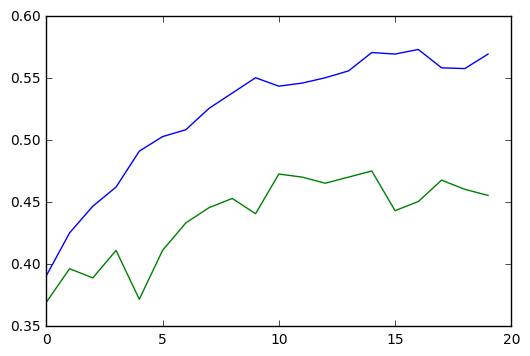

the final accuracy on the validation set is 0.45566502463054187


In [6]:
network_params = {
    "batch_size": batch_size,
    "weight_decay": weight_decay,
    "input_dim": number_of_input_pixels,
    "output_dim": num_classes
}

output_dim_hidden_layer_li = [75, 20, num_classes]

get_network = GetNetwork(
    network_params,
    output_dim_hidden_layer_li,
    params_lin_layer_li
)

trained_network = get_network.get_trained_network(X_train, y_train, num_iterations)

#### First, import functions to calculuate information theory measures. 

In [7]:
from information_theory.info_theory import calculate_mutual_information
from information_theory.info_theory import points_to_dist

 to calculate mutual information


In [47]:

def create_freq_table(df, output_network):    
    """create a dataframe with the number of outcomes given
       the outcome of the network
    
    params: 
        df: Dataframe where every row is a possible outcome. 
            There may be duplicates. 
        output_network: numpy array with the corresponding 
            ouput for the network given the (whole picture
            from which the outcome in the row was selected)
            by sampling some pixels) as input. The first value
            in the np array corresponds to the first row etc.
    """

    
    square = output_network==0
    circle = output_network==1
    rectangle = output_network==2

    df["square"] = pd.Series(square.astype('int'))
    df["circle"] = pd.Series(circle.astype('int'))
    df["rectangle"] = pd.Series(rectangle.astype('int'))
    
    grouped = df.groupby(list(df.columns[:-3]), as_index=True)
    df2 = grouped.aggregate(np.sum)
    df2['x_freq'] = df2.iloc[:, -3:].apply(np.sum, 1)
    return df2

def one_hot_to_number(vec):
    return np.argmax(vec, axis=1)

def get_output_network(network, X, number_of_classes):
    """produce the ouput of the network for all pictures in X"""
    out_distribution = np.zeros((X.shape[0], number_of_classes))
    batch_size = network.batch_size
    number_of_batches = int(X.shape[0]/batch_size)
    for i in range(number_of_batches):
        out_distribution[i*batch_size:(i+1)*batch_size] = (
            network.forward(X[i*batch_size:(i+1)*batch_size]) 
        )
    network.update_batch_size(1)
    for i in range(number_of_batches*network.batch_size, X.shape[0]):
        out_distribution[i] = network.forward(np.array([X[i]])) 
        
    network.update_batch_size(batch_size)
    
    #make sure batch_size is set back correctly
    network.forward(X[:batch_size])
    
    return one_hot_to_number(out_distribution)
        
def calculate_mutual_info_distribution():
    """return a li with all mutual info values"""
    return []
    
def calculate_mutual_information(freq_df):
    """calculate the mutual information given dataframe 
       holding the frequencies
    
    returns: the mutual information
    """
    #take the sum of every category column divide by total
    total_number_of_outcomes = freq_df["x_freq"].sum()
    
    output_distribution = {}
    for category in freq_df.columns:
        if category != "x_freq":
            output_distribution[category] = (
                freq_df[category].sum()/total_number_of_outcomes
            )
            
    dist_x = freq_df.loc[:, ["x_freq"]]/freq_df.loc[:, ["x_freq"]].sum()
    dist_x = dist_x.iloc[:, 0]
    mutual_information = 0
    for category in freq_df.columns:
        if category != "x_freq":
            remove_zeros_mask = freq_df.loc[:, category] != 0
            prob_x_given_y = (
                freq_df[remove_zeros_mask].loc[:, category] /
                freq_df.loc[:, category].sum()
            )
            mutual_information = mutual_information + sum( 
                output_distribution[category] *
                prob_x_given_y *
                prob_x_given_y.divide(dist_x[remove_zeros_mask]).map(np.log2)
            )
            
    return mutual_information

def batch_sample_mutual_info(all_pictures, number_of_networks, 
                             max_selected_input_pixels, number_of_positions,
                             network_type):
    """calculate average mutual information between n 
       input pixels and output by sampling for different 
       networks, position of pixels and amount of input pixels
    
    returns: a list of dicts, every entry in the list resembles one
        network. The keys from the dict are the amount of pixels sampled
        from and the values the calculated mutual information scores 
        for different positions
    """
    network_mutual_info_li = []
    for i in range(number_of_networks):
        if network_type=="trained":
            network = get_network.get_trained_network(X_train, y_train, num_iterations)
        elif network_type=="random": 
            network = get_network.get_random_network()
        output_network = get_output_network(network, all_pictures, 3)
        if output_network.shape[0] != all_pictures.shape[0]:
            print("the length of the input {} and length output {}".format(
                X.shape[0], output_network.shape[0]
            ))
            raise ValueError("something went wrong while calculating output")
            
        start = time.time()
        mutual_information_for_n_pixels = {}
        for number_of_pixels in range(150, max_selected_input_pixels):
            print("number of pixels: {} and time: {}".format(
                    number_of_pixels, time.time()-start
            ))
            mutual_information_li = []
            for sample_pos in range(number_of_positions):
                #select position of pixels at random
                position_pixels = np.random.randint(
                    all_pictures.shape[1], size=number_of_pixels
                )
                sel_pixels_all_pictures = all_pictures[:, position_pixels]
                freq_df = create_freq_table(
                    pd.DataFrame(sel_pixels_all_pictures),
                    output_network
                )
                if all_pictures.shape[0] != freq_df["x_freq"].sum():
                    print("all outcome should be {} but is {}".format(
                        all_pictures.shape[0], freq_df["x_freq"].sum()
                    ))
                    raise ValueError("calculation fo freq_df has gone wrong")

                mutual_information_li.append(calculate_mutual_information(freq_df))
                
            mutual_information_for_n_pixels[number_of_pixels] = mutual_information_li
            
        network_mutual_info_li.append(mutual_information_for_n_pixels)
            
    return network_mutual_info_li
        
    

test methods to calculate mutual information

In [40]:
freq_df_example = pd.DataFrame(
    np.array(
        [
            [1, 2, 3],
            [3, 0, 3],
            [2, 2, 4]
        ]
    ),
    columns = ["square", "rectangle", "x_freq"]
)

exp_mutual_info = (
    (1/6)*(6/10) * np.log2((1/6)/(3/10)) +
    (3/6)*(6/10) * np.log2((3/6)/(3/10)) +
    (2/6)*(6/10) * np.log2((2/6)/(4/10)) +
    (2/4)*(4/10) * np.log2((2/4)/(3/10)) +
    (2/4)*(4/10) * np.log2((2/4)/(4/10))
)
    
mutual_info = calculate_mutual_information(freq_df_example)
assert abs(exp_mutual_info-mutual_info) < 1e-6

test create frequency table

In [41]:
picture_selected_pixels = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 1],
    [0, 0, 1],
    [1, 1, 1],
    [1, 1, 0],
    [0, 1, 0]
])

df = pd.DataFrame(picture_selected_pixels)

classification_deep_network = np.array(
    [0, 2, 1, 2, 1, 2, 2]
)

freq_df = create_freq_table(df, classification_deep_network)
exp_freq_table = np.array([
    [0, 0, 2, 2],
    [1, 0, 1, 2],
    [0, 0, 1, 1],
    [0, 2, 0, 2]
])
assert np.all(exp_freq_table == freq_df.values)

test output network

In [42]:
network = get_network.get_random_network()
X = X_train[:1010]
print(X.shape)
number_of_classes = 3

out = get_output_network(network, X, number_of_classes)
print(out.shape)
print(len(out[out==0]))

(1010, 256)
(1010,)
63


test batch_sample_mutual_info

number of pixels: 2 and time: 3.814697265625e-06
number of pixels: 3 and time: 1.1530697345733643
number of pixels: 4 and time: 2.229555130004883
number of pixels: 5 and time: 3.372213363647461
number of pixels: 6 and time: 4.5969929695129395
number of pixels: 7 and time: 5.920613527297974
number of pixels: 8 and time: 7.3319220542907715
number of pixels: 9 and time: 8.843064546585083
number of pixels: 10 and time: 10.457294464111328
number of pixels: 11 and time: 12.179556131362915
number of pixels: 12 and time: 14.030570983886719
number of pixels: 13 and time: 16.0408833026886
number of pixels: 14 and time: 18.241140365600586
number of pixels: 15 and time: 20.553696155548096
number of pixels: 16 and time: 23.228995084762573
number of pixels: 17 and time: 25.852997303009033
number of pixels: 18 and time: 28.679668188095093
number of pixels: 19 and time: 31.69126009941101
number of pixels: 20 and time: 34.91713213920593
number of pixels: 21 and time: 38.44544267654419
number of pixels:

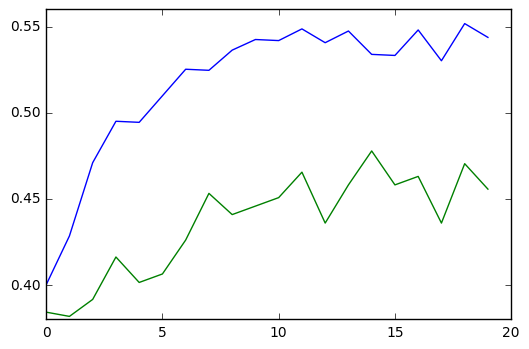

the final accuracy on the validation set is 0.45566502463054187
number of pixels: 2 and time: 6.4373016357421875e-06
number of pixels: 3 and time: 1.069411277770996
number of pixels: 4 and time: 2.1955347061157227
number of pixels: 5 and time: 3.5067591667175293
number of pixels: 6 and time: 4.797475576400757
number of pixels: 7 and time: 6.1528942584991455
number of pixels: 8 and time: 7.584891319274902
number of pixels: 9 and time: 9.141942501068115
number of pixels: 10 and time: 10.79824447631836
number of pixels: 11 and time: 12.555209875106812
number of pixels: 12 and time: 14.446022987365723
number of pixels: 13 and time: 16.462170600891113
number of pixels: 14 and time: 18.650984525680542
number of pixels: 15 and time: 21.050446033477783
number of pixels: 16 and time: 23.568018198013306
number of pixels: 17 and time: 26.293636322021484
number of pixels: 18 and time: 29.23203420639038
number of pixels: 19 and time: 32.39862680435181
number of pixels: 20 and time: 35.7188069820404

In [43]:
mean_mutual_info_random_network = batch_sample_mutual_info(
    all_pictures, number_of_networks=1, max_selected_input_pixels=100, 
    number_of_positions=100, network_type="random"
)

mean_mutual_info_trained_network = batch_sample_mutual_info(
    all_pictures, number_of_networks=1, max_selected_input_pixels=100, 
    number_of_positions=100, network_type="trained"
)


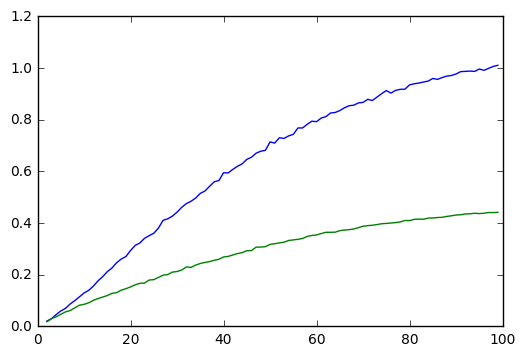

In [44]:
#print(mean_mutual_info)
num_pixel_li_random_network, mutual_info_average_li_random_network = [], []
for item in mean_mutual_info_random_network:
    for k, v in item.items():
        num_pixel_li_random_network.append(k)
        mutual_info_average_li_random_network.append(np.mean(v))
        
num_pixel_li_trained_network, mutual_info_average_li_trained_network = [], []
for item in mean_mutual_info_trained_network:
    for k, v in item.items():
        num_pixel_li_trained_network.append(k)
        mutual_info_average_li_trained_network.append(np.mean(v))
    
plt.plot(num_pixel_li_trained_network, mutual_info_average_li_trained_network)
plt.plot(num_pixel_li_random_network, mutual_info_average_li_random_network)
plt.show()

starting validation accuracy 0.33251231527093594


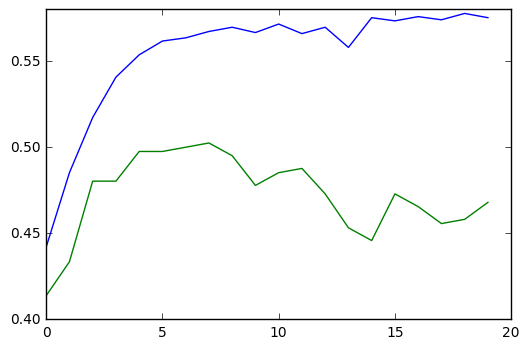

the final accuracy on the validation set is 0.46798029556650245
number of pixels: 150 and time: 9.059906005859375e-06


In [48]:
mean_mutual_info_trained_network = batch_sample_mutual_info(
    all_pictures, number_of_networks=1, max_selected_input_pixels=151, 
    number_of_positions=100, network_type="trained"
)

In [49]:
print(np.mean(mean_mutual_info_trained_network[0][150]))

1.3017413485


In [ ]:
plt.legend(loc=2,prop={'size':6})
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20

plot_data = np.arange(0, 9, 1)
plot_trained_network_mean = np.mean(np.array(plot_data_trained_network), axis=0)
plot_trained_network_std = np.std(np.array(plot_data_trained_network), axis=0)
lower_bound_trained_network = plot_trained_network_mean-plot_trained_network_std 
upper_bound_trained_network = plot_trained_network_mean+plot_trained_network_std

plot_random_network_mean = np.mean(np.array(plot_data_random_network), axis=0)
plot_random_network_std = np.std(np.array(plot_data_random_network), axis=0)
lower_bound_random_network = plot_random_network_mean-plot_random_network_std
upper_bound_random_network = plot_random_network_mean+plot_random_network_std 

plot_actual_values_mean = np.mean(np.array(plot_data_actual_values), axis=0)
plot_actual_values_std = np.std(np.array(plot_data_actual_values), axis=0)

plt.plot(plot_trained_network_mean, label="mean trained network")
plt.fill_between(plot_data, lower_bound_trained_network, 
                 upper_bound_trained_network, alpha=0.3)

plt.plot(plot_random_network_mean, label="mean random network")
plt.fill_between(plot_data, lower_bound_random_network, 
                 upper_bound_random_network, alpha=0.3)

plt.plot(plot_actual_values_mean, label="mean actual outputs")
#plt.fill_between(plot_data, 
#                 plot_actual_values_mean-plot_actual_values_std,
#                 plot_random_network_mean+plot_actual_values_std,
#                 alpha=0.3)

plt.title("Mutual information between randomly selected pixels and network output")
plt.xlabel("number of variables")
plt.ylabel("mean mutual information between pixels and output network")
plt.legend()
plt.show()

In [ ]:


def get_prob(network, pos_pixels, value_pixels, y, y_hat):
    #from all pictures select those where y, y_hat match
    sel_pictures = [picture for picture in pictures[y] 
                    if network.calculate_forward(picture) == y_hat]

    #from those pictures calculate what percentage has 
    #the values of the pixels at the right positions
    if sel_pictures == []:
        return 0
    else:
        return sum(
            [1 for picture in sel_pictures if picture[pos_pixels] == value_pixels]
        )/len(sel_pictures)

def calculate_probability(network, pos_pixels, value_pixels):
    #calculate P(x|y_hat) for every value of y_hat 
    #x represents the value of certain pixels and y_hat the output of the ANN
    
    prob_li = []
    for y_hat in range(num_classes):
        #calculate p(y|y_hat) and p(y_hat) upfront 
        #prob = sum_y (p(x|y, y_hat) * p(y|y_hat) * p(y_hat))
        prob = 0
        for y in range(num_classes):
            prob = prob + (
                get_prob(network, pos_pixels, value_pixels, y, y_hat) *
                prob_y_given_y_hat[(y, y_hat)] *
                prob_y_hat[y_hat]
            )
        prob_li.append(prob)
        
    return prob_li
    




legacy code in the cells following:

In [ ]:
def one_hot_to_number(vec):
    return np.argmax(vec, axis=1)

def create_distributions(X, out, batch_size, max_amount_variables):
    """compute the average mutual information between input and ouput
    
    note: the amount of input pixels used is variable  
    """
    
    num_pictures = X.shape[0]
    unique_out, counts_out = np.unique(out, return_counts=True)
    out_dist = counts_out/np.sum(counts_out)
    mutual_info_dict = {}
    
    for i in range(1, max_amount_variables):
        pixel_arr = np.zeros((num_pictures, i))
        pixel_plus_outcome_arr = np.zeros((num_pictures, i+1))
        pixel_plus_outcome_arr[:, -1:] = np.transpose(np.array([out]))
        mutual_info_li = []
        for batch_number in range(batch_size):
            position_points = np.random.randint(grid_len*grid_width, size=i)  
            pixel_arr = X[:, position_points]
            pixel_plus_outcome_arr[:, :-1] = pixel_arr
            
            pixel_dist = points_to_dist(pixel_arr)
            mutual_dist = points_to_dist(pixel_plus_outcome_arr)
            
            mutual_info = calculate_mutual_information(pixel_dist, out_dist, mutual_dist)
            mutual_info_li.append(mutual_info)
            
        mutual_info_dict[i] = mutual_info_li
        
    return mutual_info_dict

def get_output_network(network, X, shape_output, number_of_batches):
    out_one_hot = np.zeros((shape_output))
    batch_size = network.batch_size
    for i in range(number_of_batches):
        out_one_hot[i*batch_size:(i+1)*batch_size] = (
            network.forward(X[i*batch_size:(i+1)*batch_size]) 
        )
    return one_hot_to_number(out_one_hot)
    
def get_mutual_info_network(get_network, number_of_batches=50, max_amount_variables=10):
    gen = generator.GenerateData(grid_len, grid_width, add_noise=False, params=None)
    X, y = gen.generate_batch_samples(batch_size=number_of_batches*batch_size)
    
    batch_size_sampling_distributions = 100
    plot_data = []
    for i in range(10):
        out = get_output_network(get_network(), X, y.shape, number_of_batches)
        mutual_info_dict = create_distributions(X, out, batch_size_sampling_distributions, max_amount_variables)
        plot_data.append([np.mean(v) for k, v in mutual_info_dict.items()])
        #for k, v in mutual_info_dict.items():
        #    print("number of variables {}, mean mutual info {}".format(k, np.mean(v)))

    return plot_data

In [ ]:
print("get a random network")
plot_data_random_network = get_mutual_info_network(get_random_network)
print("get a trained network")
plot_data_trained_network = get_mutual_info_network(get_trained_network)
plot_data_actual_values = []
for i in range(10):
    out = one_hot_to_number(out_one_hot)
    mutual_info_dict = create_distributions(X, out, batch_size=30, max_amount_variables=10)
    plot_data_actual_values.append([np.mean(v) for k, v in mutual_info_dict.items()])

In [ ]:
plt.legend(loc=2,prop={'size':6})
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20

plot_data = np.arange(0, 9, 1)
plot_trained_network_mean = np.mean(np.array(plot_data_trained_network), axis=0)
plot_trained_network_std = np.std(np.array(plot_data_trained_network), axis=0)
lower_bound_trained_network = plot_trained_network_mean-plot_trained_network_std 
upper_bound_trained_network = plot_trained_network_mean+plot_trained_network_std

plot_random_network_mean = np.mean(np.array(plot_data_random_network), axis=0)
plot_random_network_std = np.std(np.array(plot_data_random_network), axis=0)
lower_bound_random_network = plot_random_network_mean-plot_random_network_std
upper_bound_random_network = plot_random_network_mean+plot_random_network_std 

plot_actual_values_mean = np.mean(np.array(plot_data_actual_values), axis=0)
plot_actual_values_std = np.std(np.array(plot_data_actual_values), axis=0)

plt.plot(plot_trained_network_mean, label="mean trained network")
plt.fill_between(plot_data, lower_bound_trained_network, 
                 upper_bound_trained_network, alpha=0.3)

plt.plot(plot_random_network_mean, label="mean random network")
plt.fill_between(plot_data, lower_bound_random_network, 
                 upper_bound_random_network, alpha=0.3)

plt.plot(plot_actual_values_mean, label="mean actual outputs")
#plt.fill_between(plot_data, 
#                 plot_actual_values_mean-plot_actual_values_std,
#                 plot_random_network_mean+plot_actual_values_std,
#                 alpha=0.3)

plt.title("Mutual information between randomly selected pixels and network output")
plt.xlabel("number of variables")
plt.ylabel("mean mutual information between pixels and output network")
plt.legend()
plt.show()

In [ ]:
import pandas as pd

a = pd.DataFrame(np.array([[1,2,1],[1,2,2],[1,2,1], [1,1,1], [1,2,2], [2,1,2]]))
print("a equals")
print(list(a.columns))

b = a.groupby([0,1,2])
c = pd.DataFrame(b.size()).values.flatten()
print("c equals")
print(c)

d = c/c.sum()
print(d)
print(d.values)

In [ ]:
import pandas as pd

out_come_ANN = {
    "square": np.array([[0,1,1],[0,0,1],[0,1,1]],
                       [[0,0,0],[0,0,1],[0,1,1]], 
                       [[1,0,0],[1,0,1],[1,1,1]])

data_len = len([out_come_ANN[cat].shape[0] for cat in out_come_ANN.keys()])



Below the algorithm to generate the appropriate distributions is outlined on a simple test case

In [ ]:
import numpy as np
import pandas as pd

picture_selected_pixels = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 1],
    [0, 0, 1],
    [1, 1, 1],
    [1, 1, 0],
    [0, 1, 0]
])

df = pd.DataFrame(picture_selected_pixels)

classification_deep_network = np.array(
    [1, 3, 2, 3, 2, 3, 3]
)

def create_freq_tables(df, output_network):    
    square = output_network==1
    circle = output_network==2
    rectangle = output_network==3

    df["square"] = pd.Series(square.astype('int'))
    df["circle"] = pd.Series(circle.astype('int'))
    df["rectangle"] = pd.Series(rectangle.astype('int'))

    print(df)
    grouped = df.groupby(list(df.columns[:-3]), as_index=True)
    df2 = grouped.aggregate(np.sum)
    print(df2)

    print(df2.iloc[:, -3:])
    print(df2.iloc[:, -3:].apply(np.sum, 1))
    df2['x_freq'] = df2.iloc[:, -3:].apply(np.sum, 1)

    return df2
    
print(create_freq_tables(df, classification_deep_network))


In [ ]:
import numpy as np
import pandas as pd

a = np.array([[1,2,3], [-2,5,6], [7,8,9]])

a_df = pd.DataFrame(a)
zero_filter = a_df.loc[:, 0]>0
print(zero_filter)
print(a_df[zero_filter])

#a[:, np.array([0,2])]

In [45]:
16*16


256